In [51]:
# -*- coding:utf-8 -*-
# @Python Version: 3.7
# @Time: 2020/12/3 19:52
# @Author: Michael Ming
# @Website: https://michael.blog.csdn.net/
# @File: emotion_analysis.py
# @Reference:

import numpy as np
import pandas as pd

data = pd.read_csv("yelp_labelled.txt", sep='\t', names=['sentence', 'label'])

data.head() # 1000条数据

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [52]:
# 数据 X 和 标签 y
sentence = data['sentence'].values
label = data['label'].values

In [53]:
# 训练集 测试集拆分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentence, label, test_size=0.3, random_state=1)

In [54]:
# 文本向量化
import keras
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X_train) # 训练tokenizer
X_train = tokenizer.texts_to_sequences(X_train) # 转成 [ids...]
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index)+1

KeyboardInterrupt: 

In [43]:
maxlen = 100
# pad 保证每个句子的长度相等
from keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
# post 尾部补0，pre 前部补0
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

In [44]:
from keras import layers
embeddings_dim = 150
filters = 64
kernel_size = 5
batch_size = 64


nn_model = keras.Sequential()
nn_model.add(layers.Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=maxlen))
nn_model.add(layers.Conv1D(filters=filters,kernel_size=kernel_size,activation='relu'))
nn_model.add(layers.GlobalMaxPool1D())
nn_model.add(layers.Dropout(0.3))
# 上面 GlobalMaxPool1D 后，维度少了一维，下面自定义layers再扩展一维
nn_model.add(layers.Lambda(lambda x : keras.backend.expand_dims(x, axis=-1)))
nn_model.add(layers.Conv1D(filters=filters,kernel_size=kernel_size,activation='relu'))
nn_model.add(layers.GlobalMaxPool1D())
nn_model.add(layers.Dropout(0.3))
nn_model.add(layers.Dense(10, activation='relu'))
nn_model.add(layers.Dense(1, activation='sigmoid')) # 二分类sigmoid, 多分类 softmax

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 150)          251400    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 96, 64)            48064     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 64, 1)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 60, 64)            384       
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 64)               

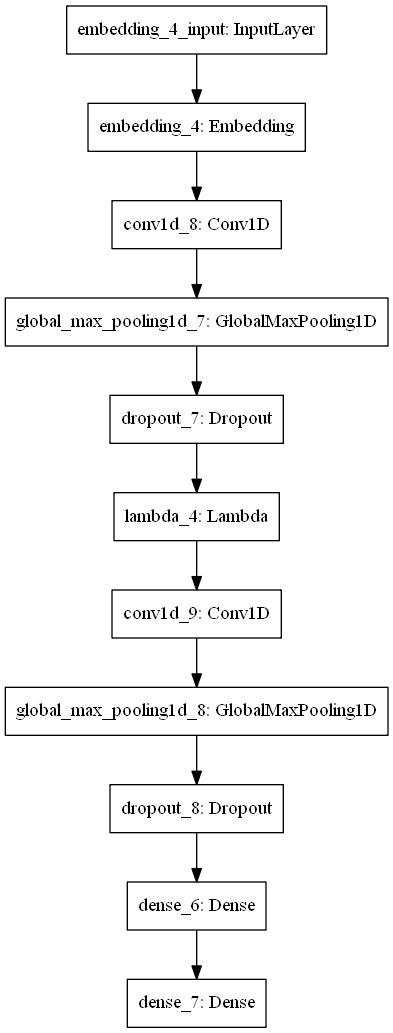

In [45]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
nn_model.summary()
from keras.utils import plot_model
plot_model(nn_model, to_file='model.jpg')


In [46]:
nn_model.fit(X_train,y_train,batch_size=batch_size,
             epochs=50,verbose=2,validation_data=(X_test,y_test))
# verbose 是否显示日志信息，0不显示，1显示进度条，2不显示进度条
loss, accuracy = nn_model.evaluate(X_train, y_train, verbose=1)
print("训练集：loss {0:.3f}, 准确率：{1:.3f}".format(loss, accuracy))
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=1)
print("测试集：loss {0:.3f}, 准确率：{1:.3f}".format(loss, accuracy))

Epoch 1/50
11/11 - 1s - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6933 - val_accuracy: 0.4633
Epoch 2/50
11/11 - 0s - loss: 0.6931 - accuracy: 0.5214 - val_loss: 0.6935 - val_accuracy: 0.4633
Epoch 3/50
11/11 - 1s - loss: 0.6930 - accuracy: 0.5257 - val_loss: 0.6936 - val_accuracy: 0.4633
Epoch 4/50
11/11 - 0s - loss: 0.6926 - accuracy: 0.5429 - val_loss: 0.6936 - val_accuracy: 0.4633
Epoch 5/50
11/11 - 1s - loss: 0.6916 - accuracy: 0.5557 - val_loss: 0.6939 - val_accuracy: 0.4700
Epoch 6/50
11/11 - 1s - loss: 0.6868 - accuracy: 0.6457 - val_loss: 0.6930 - val_accuracy: 0.4767
Epoch 7/50
11/11 - 1s - loss: 0.6750 - accuracy: 0.7771 - val_loss: 0.6872 - val_accuracy: 0.6067
Epoch 8/50
11/11 - 1s - loss: 0.6472 - accuracy: 0.8386 - val_loss: 0.6749 - val_accuracy: 0.6867
Epoch 9/50
11/11 - 1s - loss: 0.5915 - accuracy: 0.8929 - val_loss: 0.6508 - val_accuracy: 0.6967
Epoch 10/50
11/11 - 1s - loss: 0.5068 - accuracy: 0.9271 - val_loss: 0.6181 - val_accuracy: 0.6900
Epoch 11/50
11/11 -

In [47]:
text = ["i am not very good.", "i am very good."]
x = tokenizer.texts_to_sequences(text)
x = pad_sequences(x, maxlen=maxlen, padding='post')
pred = nn_model.predict(x)
print("预测{}的类别为：".format(text[0]), 1 if pred[0][0]>=0.5 else 0)
print("预测{}的类别为：".format(text[1]), 1 if pred[1][0]>=0.5 else 0)


预测i am not very good.的类别为： 0
预测i am very good.的类别为： 1
